In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.dates as dts
import fredpy as fp
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
# 0. load fred api key
fp.api_key = fp.load_api_key('fred_api_key.txt')

# format the x axis ticksticks
years2,years4,years5,years10,years15= dts.YearLocator(2),dts.YearLocator(4),dts.YearLocator(5),dts.YearLocator(10),dts.YearLocator(15)


myFmt = dts.DateFormatter('%Y')

In [3]:
# 1. Setup for the construction of K and A

# 1.1 Parameters for the model
alpha = 0.35

# 1.2 Number of years to average K/Y to compute initial K/Y ratio (and therefore intial K)
N = 10

# 1.3 If output_solow == TRUE, then Y = C + I.  Else: Y = C + I + G + NX (default)
output_solow = False

# 1.4 Define the function for computing the capital series
def capitalSeries(i,k0,delta):
    t0 = len(i)-1
    k = [k0]
    for t in range(t0):
        k.append(i[t]+(1-delta)*k[t])

    return np.array(k)

In [4]:
# 2. Import and manage data from FRED

# 2.1 Annual data
investmentA = fp.series('GPDIA')
consumptionA = fp.series('PCECA')
governmentA = fp.series('GCEA')
exportsA = fp.series('EXPGSA')
importsA = fp.series('IMPGSA')
netExportsA = fp.series('A019RC1A027NBEA')
deflatorA = fp.series('A191RD3A086NBEA')
# depreciationA = fp.series('Y0000C1A027NBEA')  # Current-Cost Depreciation of Fixed Assets
depreciationA = fp.series('M1TTOTL1ES000')      # Consumption of fixed capital: Private: Domestic business: Capital consumption allowances 
gdpA = fp.series('GDPA')
tfpA = fp.series('GDPA')
capitalA = fp.series('GDPA')
laborA = fp.series('B4701C0A222NBEA')

investmentA,consumptionA,governmentA,netExportsA,exportsA,importsA,deflatorA,depreciationA,gdpA,tfpA,capitalA,laborA = fp.window_equalize([investmentA,consumptionA,governmentA,netExportsA,exportsA,importsA,deflatorA,depreciationA,gdpA,tfpA,capitalA,laborA])

# 2.2 Compute real annual data series
investmentA.data= 100*investmentA.data/deflatorA.data
consumptionA.data = 100*consumptionA.data/deflatorA.data
governmentA.data = 100*governmentA.data/deflatorA.data
exportsA.data = 100*exportsA.data/deflatorA.data
importsA.data = 100*importsA.data/deflatorA.data
netExportsA.data = 100*netExportsA.data/deflatorA.data
depreciationA.data = 100*depreciationA.data/deflatorA.data/1000 # Because units are millions, not billions
gdpA.data= 100*gdpA.data/deflatorA.data

# 2.3 Convert labor from millions of hours to billions
laborA.data = laborA.data/1000

# 2.4 Quarterly data
investmentQ  = fp.series('GPDI')
investmentQ4  = fp.series('GPDI')
consumptionQ  = fp.series('PCEC')
governmentQ = fp.series('GCE')
exportsQ = fp.series('EXPGS')
importsQ = fp.series('IMPGS')
netExportsQ = fp.series('NETEXP')
deflatorQ  = fp.series('GDPDEF')


In [5]:
gdpQ  = fp.series('GDP')
tfpQ  = fp.series('GDP')
capitalQ  = fp.series('GDP')
laborQ = fp.series('HOANBS')

investmentQ,investmentQ4,consumptionQ,governmentQ,netExportsQ,exportsQ,importsQ,deflatorQ,gdpQ,tfpQ,capitalQ,laborQ = fp.window_equalize([investmentQ,investmentQ4,consumptionQ,governmentQ,netExportsQ,exportsQ,importsQ,deflatorQ,gdpQ,tfpQ,capitalQ,laborQ])

# 2.5 Compute real annual data series
investmentQ.data= 100*investmentQ.data/deflatorQ.data
investmentQ4.data= 100*investmentQ4.data/deflatorQ.data
consumptionQ.data = 100*consumptionQ.data/deflatorQ.data
governmentQ.data = 100*governmentQ.data/deflatorQ.data
netExportsQ.data = 100*netExportsQ.data/deflatorQ.data
exportsQ.data = 100*exportsQ.data/deflatorQ.data
importsQ.data = 100*importsQ.data/deflatorQ.data
gdpQ.data= 100*gdpQ.data/deflatorQ.data

# 2.6 Compute real annual data series. Note that investment is at a quarterly rate
investmentQ4.data= investmentQ.data/4
realGdpQ= 100*gdpQ.data/deflatorQ.data

# 2.7 Find the base year for the deflator:
baseYear = deflatorA.units[6:10]
laborBaseYear= laborQ.units[6:10]

In [6]:
# 3. Parameter calibration using the annual series

# 3.1 Use Y = C + I as the measure for output if that was requested above
if output_solow == True:
    gdpA.data = consumptionA.data+investmentA.data
    gdpQ.data = consumptionQ.data+investmentQ.data

# F.2 form the ratios of depreciation and investment to output
delta = np.mean(depreciationA.data/gdpA.data)
iYRatio = np.mean(investmentA.data/gdpA.data)

g = (gdpA.data.iloc[-1]/gdpA.data.iloc[0])**(1/len(gdpA.data))-1
n = (laborA.data.iloc[-1]/laborA.data.iloc[0])**(1/len(laborA.data))-1

# 3.5 print the computed rates for inspection
print('delta:',round(delta,5))
print('s:    ',round(iYRatio,5))
print('g:    ',round(g,5))
print('n:    ',round(n,5))

delta: 0.14099
s:     0.17381
g:     0.03061
n:     0.01294


In [7]:
# 4. Implement the perpetual inventory method

# 4.1 Define two functions for calibrating the initial values for capital
def calibrate_initial_K_annual(k0A):
    capitalA = capitalSeries(investmentA.data,k0A,delta)
    return capitalA[0]/gdpA.data.values[0] - np.mean(capitalA[:N]/gdpA.data.values[:N])


def calibrate_initial_K_quarterly(k0Q):
    capitalQ = capitalSeries(investmentQ4.data,k0Q,delta/4)
    return capitalQ[0]/gdpQ.data.values[0] - np.mean(capitalQ[:N*4]/gdpQ.data.values[:N*4])

# 4.2 Compute the calibrated initial values of capital
k0A = fsolve(calibrate_initial_K_annual,8000)[0]
k0Q = fsolve(calibrate_initial_K_quarterly,8000)[0]

# 4.3 Annual capital series
capitalA.data = pd.Series(capitalSeries(investmentA.data,k0A,delta),index=investmentA.data.index)

# 4.4 Quarterly capital series
capitalQ.data = pd.Series(capitalSeries(investmentQ4.data,k0Q,delta/4),index=investmentQ.data.index)

# 4.5 Implied TFP vlaues
tfpA.data = gdpA.data/capitalA.data**alpha/laborA.data**(1-alpha)
tfpQ.data = gdpQ.data/capitalQ.data**alpha/laborQ.data**(1-alpha)

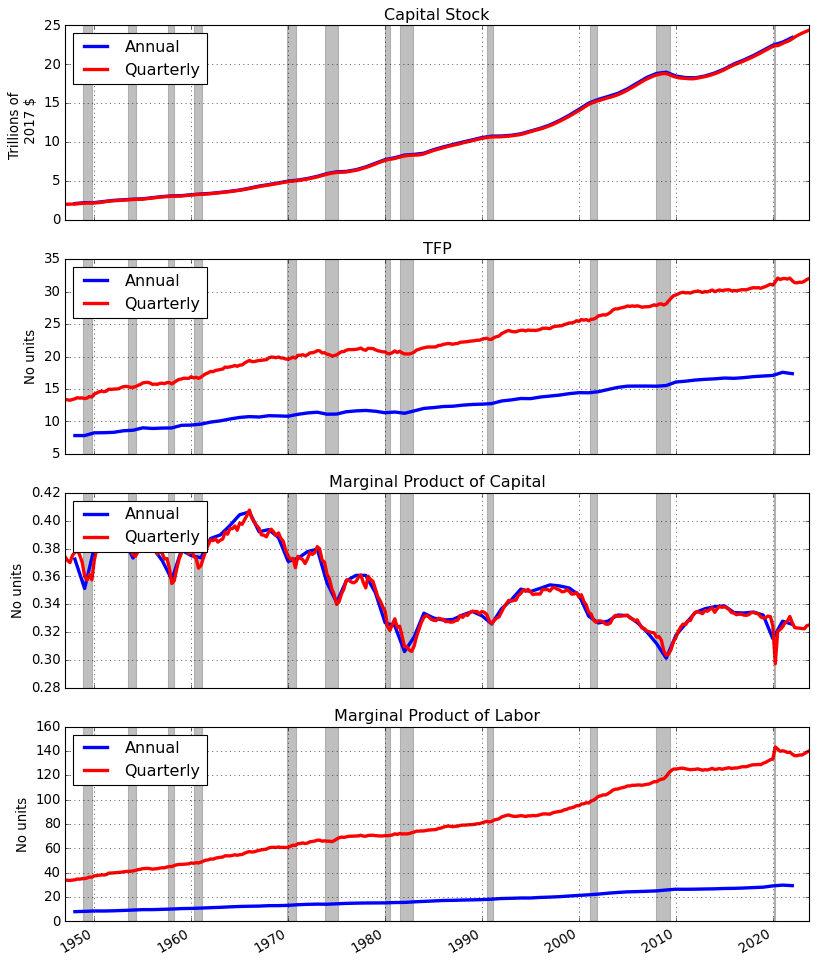

In [8]:
# 5. Plot the capital series. Note that the annual and quarterly series should and do align approximately.
fig = plt.figure(figsize=(12,16))
ax = fig.add_subplot(4,1,1)
ax.plot(capitalA.data/1000,'b-',lw = 3)
ax.plot(capitalQ.data/1000,'r-',lw = 3)
ax.set_ylabel('Trillions of \n '+baseYear+' $')
capitalA.recessions()
fig.autofmt_xdate()
plt.title('Capital Stock')
ax.legend(['Annual','Quarterly'],loc='upper left')
ax.grid(True)
# plt.savefig('../png/fig_US_Production_Capital_QA.png',bbox_inches='tight')

ax = fig.add_subplot(4,1,2)
ax.plot(tfpA.data,'b-',lw = 3)
ax.plot(tfpQ.data,'r-',lw = 3)
ax.set_ylabel('No units')
capitalA.recessions()
fig.autofmt_xdate()
plt.title('TFP')
ax.legend(['Annual','Quarterly'],loc='upper left')
ax.grid(True)
# plt.savefig('../png/fig_US_Production_Capital_QA.png',bbox_inches='tight')


ax = fig.add_subplot(4,1,3)
ax.plot(0.35*gdpA.data/capitalA.data,'b-',lw = 3)
ax.plot(0.35*gdpQ.data/capitalQ.data,'r-',lw = 3)
ax.set_ylabel('No units')
capitalA.recessions()
fig.autofmt_xdate()
plt.title('Marginal Product of Capital')
ax.legend(['Annual','Quarterly'],loc='upper left')
ax.grid(True)
# plt.savefig('../png/fig_US_Production_Capital_QA.png',bbox_inches='tight')

ax = fig.add_subplot(4,1,4)
ax.plot(0.35*gdpA.data/laborA.data,'b-',lw = 3)
ax.plot(0.65*gdpQ.data/laborQ.data,'r-',lw = 3)
ax.set_ylabel('No units')
capitalA.recessions()
fig.autofmt_xdate()
plt.title('Marginal Product of Labor')
ax.legend(['Annual','Quarterly'],loc='upper left')
ax.grid(True)
# plt.savefig('../png/fig_US_Production_Capital_QA.png',bbox_inches='tight')

In [9]:
# 6. Save data to csv files

# 6.1 Annual data
df = pd.DataFrame({
    'Year':gdpA.data.index.strftime('%Y'),
    'GDP [Bil. of '+baseYear+' Dollars]':gdpA.data.round(1),
    'Consumption [Bil. of '+baseYear+' Dollars]':consumptionA.data.round(1),
    'Investment [Bil. of '+baseYear+' Dollars]':investmentA.data.round(1),
    'Government Purchases [Bil. of '+baseYear+' Dollars]':governmentA.data.round(1),
    'Exports [Bil. of '+baseYear+' Dollars]':exportsA.data.round(1),
    'Imports [Bil. of '+baseYear+' Dollars]':importsA.data.round(1),
    'Net Exports [Bil. of '+baseYear+' Dollars]':netExportsA.data.round(1),
    'Capital [Bil. of '+baseYear+' Dollars]':capitalA.data.round(1),
    'Labor [Bil. of Hours]':laborA.data.round(4)})

df.loc['1950-01-01':].to_csv('../csv/US_Production_A_Data.csv',index=False)

# 6.2 Quarterly data
df = pd.DataFrame({
    'Date':gdpQ.data.index.strftime('%Y-%m-%d'),
    'GDP [Bil. of '+baseYear+' Dollars]':gdpQ.data.round(1),
    'Consumption [Bil. of '+baseYear+' Dollars]':consumptionQ.data.round(1),
    'Investment [Bil. of '+baseYear+' Dollars]':investmentQ.data.round(1),
    'Government Purchases [Bil. of '+baseYear+' Dollars]':governmentQ.data.round(1),
    'Exports [Bil. of '+baseYear+' Dollars]':exportsQ.data.round(1),
    'Imports [Bil. of '+baseYear+' Dollars]':importsQ.data.round(1),
    'Net Exports [Bil. of '+baseYear+' Dollars]':netExportsQ.data.round(1),
    'Capital [Bil. of '+baseYear+' Dollars]':capitalQ.data.round(1),
    'Labor [Index: '+laborBaseYear+'=100]':laborQ.data.round(1)})

df.loc['1950-01-01':].to_csv('../csv/US_Production_Q_Data.csv',index=False)

In [10]:
# 7. Compute the Solow residuals: 

# 7.1 Annual residual
capitalA_growth = capitalA.apc()
tfpA_growth = tfpA.apc()
laborA_growth = laborA.apc()
gdpA_growth = gdpA.apc()
consumptionA_growth = consumptionA.apc()
investmentA_growth = investmentA.apc()
governmentA_growth = governmentA.apc()
exportsA_growth = exportsA.apc()
importsA_growth = importsA.apc()

# 7.2. Compute the Solow residual: Quarterly
capitalQ_growth = capitalQ.apc()
tfpQ_growth = tfpQ.apc()
laborQ_growth = laborQ.apc()
gdpQ_growth = gdpQ.apc()
consumptionQ_growth = consumptionQ.apc()
investmentQ_growth = investmentQ.apc()
governmentQ_growth = governmentQ.apc()
exportsQ_growth = exportsQ.apc()
importsQ_growth = importsQ.apc()

# 7.3 Adjust starting date
capitalA_growth = capitalA_growth.window(['1950-01-01','2000-01-01'])
tfpA_growth = tfpA_growth.window(['1950-01-01','2000-01-01'])
laborA_growth = laborA_growth.window(['1950-01-01','2000-01-01'])
gdpA_growth = gdpA_growth.window(['1950-01-01','2000-01-01'])
consumptionA_growth = consumptionA_growth.window(['1950-01-01','2000-01-01'])
investmentA_growth = investmentA_growth.window(['1950-01-01','2000-01-01'])
governmentA_growth = governmentA_growth.window(['1950-01-01','2000-01-01'])
exportsA_growth = exportsA_growth.window(['1950-01-01','2000-01-01'])
importsA_growth = importsA_growth.window(['1950-01-01','2000-01-01'])

capitalQ_growth = capitalQ_growth.window(['1950-01-01','2000-01-01'])
tfpQ_growth = tfpQ_growth.window(['1950-01-01','2000-01-01'])
laborQ_growth = laborQ_growth.window(['1950-01-01','2000-01-01'])
gdpQ_growth = gdpQ_growth.window(['1950-01-01','2000-01-01'])
consumptionQ_growth = consumptionQ_growth.window(['1950-01-01','2000-01-01'])
investmentQ_growth = investmentQ_growth.window(['1950-01-01','2000-01-01'])
governmentQ_growth = governmentQ_growth.window(['1950-01-01','2000-01-01'])
exportsQ_growth = exportsQ_growth.window(['1950-01-01','2000-01-01'])
importsQ_growth = importsQ_growth.window(['1950-01-01','2000-01-01'])

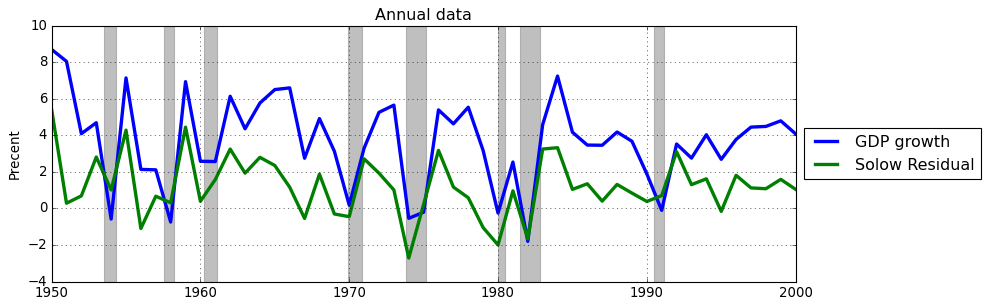

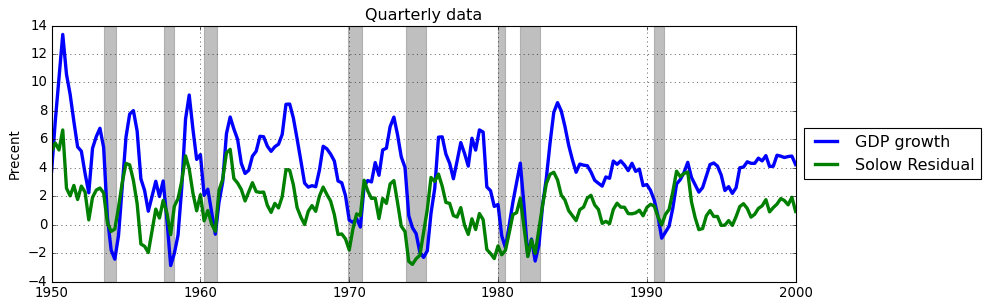

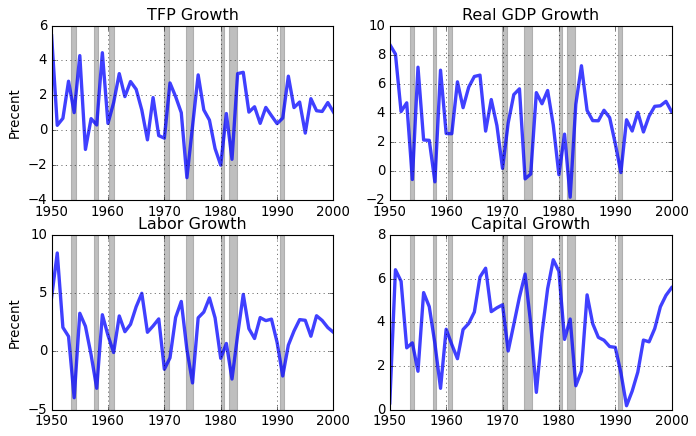

In [11]:
# 11. Construct some plots

# 11.1 Quarterly GDP growth and the Solow residual (Quarterly)
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot(1,1,1)
ax.plot(gdpA_growth.data,'b-',lw = 3)
ax.plot(tfpA_growth.data,'g-',lw = 3)
ax.xaxis.set_major_locator(years10)
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Precent')
gdpA_growth.recessions()
ax.grid(True)
ax.set_title('Annual data')
ax.legend(['GDP growth','Solow Residual'],loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('../png/fig_US_Production_ya_growth_A.png',bbox_inches='tight')

# 11.2 Quarterly GDP growth and the Solow residual (Quarterly)
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot(1,1,1)
ax.plot(gdpQ_growth.data,'b-',lw = 3)
ax.plot(tfpQ_growth.data,'g-',lw = 3)
ax.xaxis.set_major_locator(years10)
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Precent')
gdpQ_growth.recessions()
ax.grid(True)
ax.set_title('Quarterly data')
ax.legend(['GDP growth','Solow Residual'],loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('../png/fig_US_Production_ya_growth_Q.png',bbox_inches='tight')

# 11.3 Figure for website: Annual growth in Y, L, K, and A
fig = plt.figure(figsize=(10, 6)) 
ax = fig.add_subplot(2,2,1)
ax.plot(tfpA_growth.data,'b-',lw = 3,alpha = 0.75)
ax.xaxis.set_major_locator(years10)
ax.xaxis.set_major_formatter(myFmt)
ax.set_title('TFP Growth')
ax.set_ylabel('Precent')
tfpA_growth.recessions()
ax.locator_params(axis='y',nbins=6)
ax.grid(True)

ax = fig.add_subplot(2,2,2)
ax.plot(gdpA_growth.data,'b-',lw = 3,alpha = 0.75)
ax.set_title('Real GDP Growth')
ax.xaxis.set_major_locator(years10)
ax.xaxis.set_major_formatter(myFmt)
gdpA_growth.recessions()
ax.grid(True)

ax = fig.add_subplot(2,2,3)
ax.plot(laborA_growth.data,'b-',lw = 3,alpha = 0.75)
ax.xaxis.set_major_locator(years10)
ax.xaxis.set_major_formatter(myFmt)
laborA_growth.recessions()
ax.set_ylabel('Precent')
ax.set_title('Labor Growth')
ax.locator_params(axis='y',nbins=6)
ax.grid(True)

ax = fig.add_subplot(2,2,4)
ax.plot(capitalA_growth.data,'b-',lw = 3,alpha = 0.75)
ax.xaxis.set_major_locator(years10)
ax.xaxis.set_major_formatter(myFmt)
ax.set_title('Capital Growth')
ax.locator_params(axis='y',nbins=6)
capitalA_growth.recessions()
ax.grid(True)

plt.savefig('../png/fig_US_Production_A_site.png',bbox_inches='tight')

In [12]:
# 10. Save growth rate data to csv files

# 10.1 Annual data
yearsA  = pd.Series(gdpA_growth.data.index.strftime('%Y').values,index=gdpA_growth.data.index)

df = pd.concat([yearsA,gdpA_growth.data.round(1),
                consumptionA_growth.data.round(1),
                investmentA_growth.data.round(1),
                governmentA_growth.data.round(1),
                exportsA_growth.data.round(1),
                importsA_growth.data.round(1),
                capitalA_growth.data.round(1),
                laborA_growth.data.round(1)],
               axis=1)

df.columns = ['Year','GDP Growth','Consumption Growth','Investment Growth','Government Purchases Growth','Exports Growth','Imports Growth','Capital Growth','Labor Growth']

df.loc['01-01-1950':].to_csv('../csv/US_Production_A_Data_Growth_Rates.csv',index=False)


# 10.2 Quarterly data
datesQ  = pd.Series(gdpQ_growth.data.index.strftime('%Y-%m-%d').values,index=gdpQ_growth.data.index)

df = pd.concat([datesQ,gdpQ_growth.data.round(1),
                consumptionQ_growth.data.round(1),
                investmentQ_growth.data.round(1),
                governmentQ_growth.data.round(1),
                exportsQ_growth.data.round(1),
                importsQ_growth.data.round(1),
                capitalQ_growth.data.round(1),
                laborQ_growth.data.round(1)],
               axis=1)

df.columns = ['Date','GDP Growth','Consumption Growth','Investment Growth','Government Purchases Growth','Exports Growth','Imports Growth','Capital Growth','Labor Growth']

df.loc['1950-01-01':].to_csv('../csv/US_Production_Q_Data_Growth_Rates.csv',index=False)